# **Run Optuna with colsample_by_tree and num_parallel_trees too**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import cupy as cp

In [2]:
oly_train = pd.read_csv("/kaggle/input/ml-olympiad-smoking/train.csv")
oly_train.head(5)

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [3]:
ori_train = pd.read_csv("/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv")
ori_train.head(5)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
oly_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [5]:
oly_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,159256.0,79627.500000,45973.391572,0.0,39813.75,79627.5,119441.25,159255.0
age,159256.0,44.306626,11.842286,20.0,40.00,40.0,55.00,85.0
height(cm),159256.0,165.266929,8.818970,135.0,160.00,165.0,170.00,190.0
weight(kg),159256.0,67.143662,12.586198,30.0,60.00,65.0,75.00,130.0
waist(cm),159256.0,83.001990,8.957937,51.0,77.00,83.0,89.00,127.0
eyesight(left),159256.0,1.005798,0.402113,0.1,0.80,1.0,1.20,9.9
eyesight(right),159256.0,1.000989,0.392299,0.1,0.80,1.0,1.20,9.9
hearing(left),159256.0,1.023974,0.152969,1.0,1.00,1.0,1.00,2.0
hearing(right),159256.0,1.023421,0.151238,1.0,1.00,1.0,1.00,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.00,121.0,130.00,213.0


(array([12969., 11465., 13081., 65171., 15769., 13448., 22681.,  2230.,
         1760.,   682.]),
 array([20. , 26.5, 33. , 39.5, 46. , 52.5, 59. , 65.5, 72. , 78.5, 85. ]),
 <BarContainer object of 10 artists>)

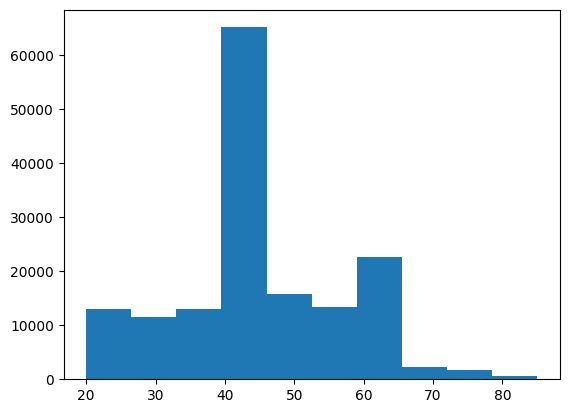

In [6]:
plt.hist(oly_train['age'])

(array([ 3592.,  2868.,  3148., 15613.,  3901.,  3451.,  5190.,   586.,
          424.,   211.]),
 array([20. , 26.5, 33. , 39.5, 46. , 52.5, 59. , 65.5, 72. , 78.5, 85. ]),
 <BarContainer object of 10 artists>)

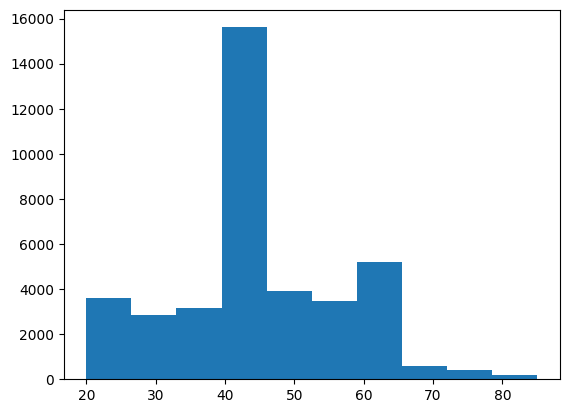

In [7]:
plt.hist(ori_train['age'])

(array([  419.,  2736., 11534., 19597., 22783., 30145., 37398., 24852.,
         8186.,  1606.]),
 array([135. , 140.5, 146. , 151.5, 157. , 162.5, 168. , 173.5, 179. ,
        184.5, 190. ]),
 <BarContainer object of 10 artists>)

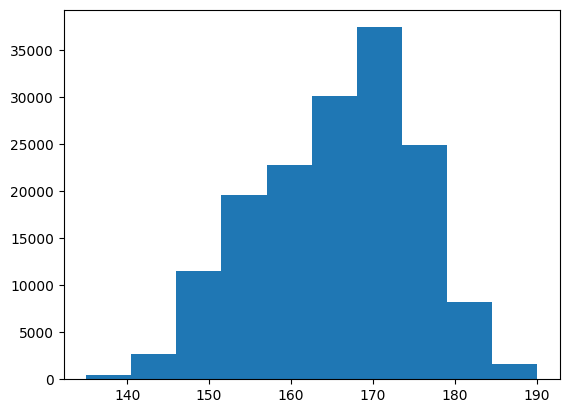

In [8]:
plt.hist(oly_train['height(cm)'])

(array([5.000e+00, 1.470e+02, 8.430e+02, 3.132e+03, 5.292e+03, 1.324e+04,
        7.985e+03, 5.617e+03, 2.203e+03, 5.200e+02]),
 array([130., 136., 142., 148., 154., 160., 166., 172., 178., 184., 190.]),
 <BarContainer object of 10 artists>)

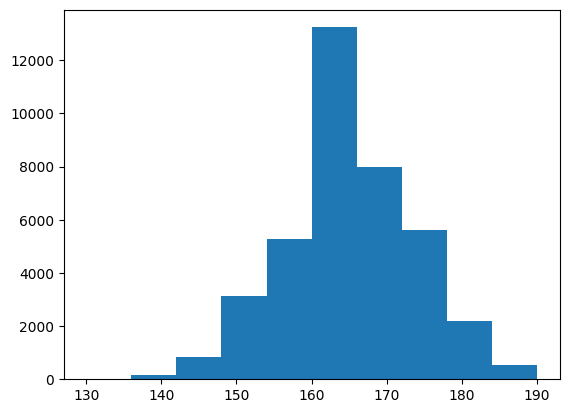

In [9]:
plt.hist(ori_train['height(cm)'])

(array([6.1000e+01, 6.3010e+03, 3.2495e+04, 4.4727e+04, 4.3867e+04,
        2.2247e+04, 7.3240e+03, 1.8920e+03, 3.1000e+02, 3.2000e+01]),
 array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130.]),
 <BarContainer object of 10 artists>)

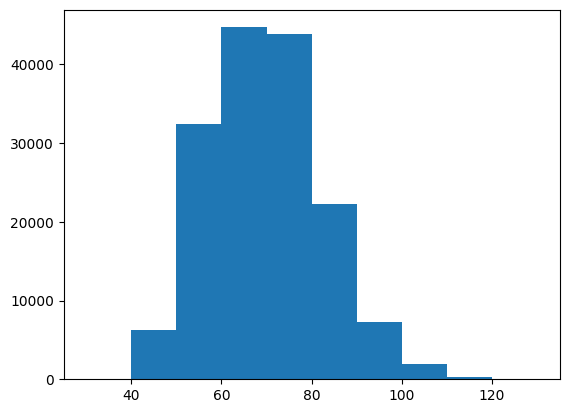

In [10]:
plt.hist(oly_train['weight(kg)'])

(array([3.5900e+02, 5.5330e+03, 1.0791e+04, 1.1146e+04, 7.1120e+03,
        2.8260e+03, 9.2600e+02, 2.2700e+02, 5.4000e+01, 1.0000e+01]),
 array([ 30. ,  40.5,  51. ,  61.5,  72. ,  82.5,  93. , 103.5, 114. ,
        124.5, 135. ]),
 <BarContainer object of 10 artists>)

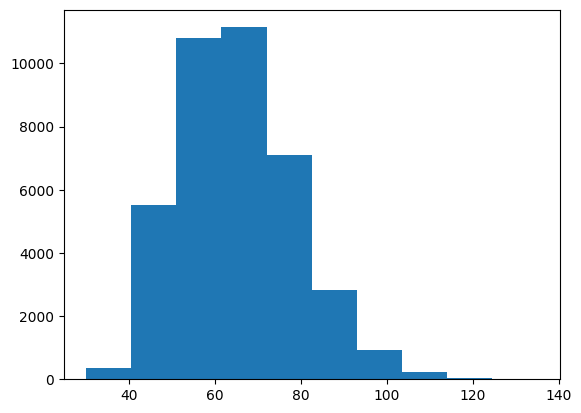

In [11]:
plt.hist(ori_train['weight(kg)'])

(array([7.2000e+01, 4.9010e+03, 1.9518e+04, 4.4042e+04, 4.8832e+04,
        3.1526e+04, 8.7930e+03, 1.3710e+03, 1.8500e+02, 1.6000e+01]),
 array([ 51. ,  58.6,  66.2,  73.8,  81.4,  89. ,  96.6, 104.2, 111.8,
        119.4, 127. ]),
 <BarContainer object of 10 artists>)

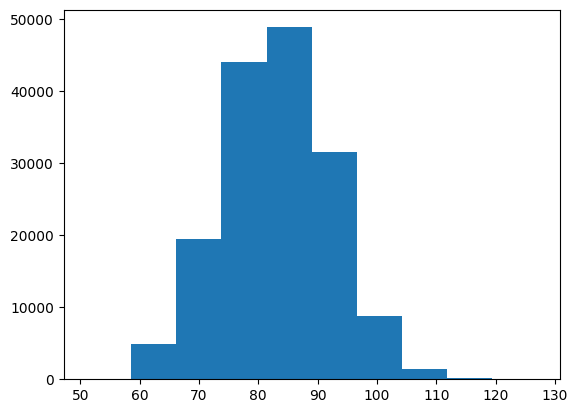

In [12]:
plt.hist(oly_train['waist(cm)'])

In [13]:
oly_train.drop('id',axis=1).corr()['smoking']

age                   -0.206033
height(cm)             0.447111
weight(kg)             0.351748
waist(cm)              0.262715
eyesight(left)         0.100420
eyesight(right)        0.109781
hearing(left)         -0.038219
hearing(right)        -0.036858
systolic               0.058642
relaxation             0.109501
fasting blood sugar    0.096534
Cholesterol           -0.051896
triglyceride           0.331975
HDL                   -0.271186
LDL                   -0.072285
hemoglobin             0.450679
Urine protein         -0.028548
serum creatinine       0.272979
AST                    0.059394
ALT                    0.163016
Gtp                    0.305561
dental caries          0.106636
smoking                1.000000
Name: smoking, dtype: float64

In [14]:
ori_train.corr()['smoking']

age                   -0.166268
height(cm)             0.394314
weight(kg)             0.299347
waist(cm)              0.223359
eyesight(left)         0.059409
eyesight(right)        0.064587
hearing(left)         -0.022077
hearing(right)        -0.018990
systolic               0.070176
relaxation             0.103663
fasting blood sugar    0.099908
Cholesterol           -0.027493
triglyceride           0.251057
HDL                   -0.179509
LDL                   -0.041627
hemoglobin             0.401206
Urine protein          0.013653
serum creatinine       0.212473
AST                    0.062834
ALT                    0.098615
Gtp                    0.240274
dental caries          0.107601
smoking                1.000000
Name: smoking, dtype: float64

In [15]:
X, y = oly_train.drop(['smoking','id'],axis=1),oly_train['smoking']

In [16]:
# def objective(trial):
#     #X_train, y_train, X_val, y_val = train_test_split(X,y,test_size=0.2,random_state = 42)
#     max_depth = trial.suggest_int("xgb_max_depth", 2, 512, log=True)
#     reg_alpha = trial.suggest_float("xgb_reg_alpha", 0.001, 0.2)
#     reg_lambda = trial.suggest_float("xgb_reg_lambda", 0.001, 0.2)
#     subsample = trial.suggest_float("xgb_subsample", 0.1, 1.0)
#     eta = trial.suggest_float("xgb_eta", 0.001, 0.3)
#     gamma = trial.suggest_float("xgb_gamma", 0.001, 0.1)
#     n_estimators = trial.suggest_int("xgb_n_estimators",100,1000)
    
#     xgbc = xgb.XGBClassifier( n_jobs=-1, max_depth = max_depth,device = 'cuda', eta = eta, reg_alpha = reg_alpha, reg_lambda = reg_lambda,subsample = subsample,eval_metric=roc_auc_score, verbosity=0 )
#     score = cross_val_score(estimator=xgbc, X=X, y=y,  cv=3,n_jobs = -1,verbose = 2).mean()
#     return score

In [17]:
# study = optuna.create_study(direction = "maximize")
# study.optimize(objective, n_trials = 500)
# trial = study.best_trial
# print("Best Score: ", trial.value)
# print("Best Params: ")
# for key, value in trial.params.items():
#     print("  {}: {}".format(key, value))

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state = 42)

In [19]:
len(y_val)

31852

In [20]:
max_depth = 6
reg_alpha = 0.03178027565100258
reg_lambda = 0.17773911707297346
subsample = 0.9726738221620005
eta = 0.16058778523232964
gamma = 0.09525201444434678
n_estimators = 600

xgbc = xgb.XGBClassifier( n_jobs=-1, max_depth = max_depth,device = 'cuda', eta = eta, reg_alpha = reg_alpha, 
                         reg_lambda = reg_lambda,subsample = subsample, colsample_bytree=0.4 ,num_parallel_tree=500, eval_metric=roc_auc_score, verbosity=0 )

In [21]:
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eta=0.16058778523232964,
              eval_metric=<function roc_auc_score at 0x7e6064a2ac20>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=500, ...)

In [22]:
roc_auc_score(y_val,xgbc.predict(X_val))

0.784059404411849

In [23]:
test = pd.read_csv("/kaggle/input/ml-olympiad-smoking/test.csv")

In [24]:
smoking = xgbc.predict_proba(test.drop('id',axis=1))[:,1]

In [25]:
submission=pd.DataFrame()
submission['smoking']=smoking
submission['id'] = test['id']
submission=submission.set_index('id')
submission

,smoking
id,
159256,0.636277
159257,0.195193
159258,0.471378
159259,0.015161
159260,0.529918
...,...
265422,0.592206
265423,0.601863
265424,0.428177


In [26]:
submission.to_csv("submission.csv",index='id')